In [1]:
import matplotlib as mpl
from pylab import *
from matplotlib import cm
import imageio
import numpy as np 
import matplotlib.pyplot as plt
from qutip import *
from IPython.display import Image

<h2>
    <center>
        General Ramsey Spectroscopy
    </center>
</h2>

Suppose that we have a pulse with turn-on time much faster than the time scale of the system. According to [Wikipedia](https://en.wikipedia.org/wiki/Bloch_sphere) a rotation about the $y$-axis of the Bloch sphere can be written as

$$
R_x(\theta) = \cos(\theta/2) \mathbb{I} - i \sin(\theta/2) \sigma_x
$$

where $\theta$ is the rotation angle of the qubit state, $\mathbb{I}$ is the identity operator, and $\sigma_x = \sigma + \sigma^\dagger$. The duration of a $\pi$-pulse is then given by $\tau = \pi/\Omega$ where $\Omega$ is the Rabi frequency. 

In [2]:
class N_dipole_system:
    def __init__(self, N):
        # Number of atoms 
        self.N = N

        ### annihilation operators ###
        idatom = qeye(2)  # identity operator
        sm = projection(2, 0, 1)  # |1><0| for an Ns-state system

        self.sm_list = []
        for i in range(N):
            op_list = [idatom] * N
            op_list[i] = sm
            self.sm_list.append(tensor(op_list))

        
        ### initial states ###
        self.ket_excited = tensor([basis(2,1) for _ in range(self.N)])  #ket( [1]*N, dim = [2] * N)
        self.ket_ground = tensor([basis(2,0) for _ in range(self.N)])  #ket( [0]*N, dim = [2] * N)

        # total spin operators
        self.id_tot = tensor([qeye(2)] * N)
        self.sm_tot = self.ket_ground * self.ket_excited.dag()
        self.sp_tot = self.sm_tot.dag()
        self.sz_tot = self.sp_tot * self.sm_tot - self.sm_tot * self.sp_tot
        self.sx_tot = self.sp_tot + self.sm_tot

        # list of states
        self.states = []
        self.H = []

    
    def Rx(self, theta, n):
        op_list = [qeye(2)] * self.N
        op_list[n] = np.cos(theta/2) * qeye(2) - 1j*np.sin(theta/2) * sigmax()
        return tensor(op_list)
    
    def pulse_sequence(self, tau, theta_list, e_op=None, points_pulse=2, points_evolve=2):
        if e_op is None:
            e_op = self.ket_excited * self.ket_excited.dag()
        self.states = [self.ket_ground]
        for n, theta in enumerate(theta_list):
            self.evolve_pulse(np.linspace(0,1,points_pulse), Omega=theta)
            if n != len(theta_list) - 1:
                self.evolve(np.linspace(0,tau,points_evolve))
        return expect(e_op, self.states[-1])
    
    def evolve_pulse(self, tlist, Omega=1, c_ops=[]):
        H = self.H *0
        for sm in self.sm_list:
            H += Omega/2*(sm + sm.dag())
        psi0 = self.states[-1]
        self.states += mesolve(H, psi0, tlist, c_ops=c_ops).states
        return self.states[-1]
    
    def evolve(self, tlist, c_ops=[]):
        psi0 = self.states[-1]
        self.states += mesolve(self.H, psi0, tlist, c_ops=c_ops).states
        return self.states[-1]

    def animate_bloch(self, fname, duration=1, save_all=False):
        n_states_to_plot = 10
        b = Bloch()
        b.vector_color = cm.Set1(np.linspace(0, 1, 9))
        b.view = [-40,30]
        images=[]
        length = len(self.states)
        ## normalize colors to the length of data ##
        nrm = mpl.colors.Normalize(0,n_states_to_plot+1)
        colors = cm.autumn(nrm(range(n_states_to_plot+1))) # options: cool, summer, winter, autumn etc.

        ## customize sphere properties ##
        color_list = list(colors) # options: 'r', 'g', 'b' etc.
        b.point_color = [c for c in color_list for _ in range(self.N)]
        b.point_marker = ['o']
        b.point_size = [30]
        
        for i in range(length):
            b.clear()
            b.add_states([self.states[i].ptrace(j) for j in range(self.N)])
            for j in range(max(0, i-n_states_to_plot), i+1):
                b.add_states([self.states[j].ptrace(n) for n in range(self.N)],'point')
            if save_all:
                b.save(dirc='tmp') #saving images to tmp directory
                filename="tmp/bloch_%01d.png" % i
            else:
                filename='temp_file.png'
                b.save(filename)
            images.append(imageio.imread(filename))
        imageio.mimsave(fname, images, duration=duration)

<h2>
    <center>
        A single atom
    </center>
</h2>

In [126]:
tlist = np.linspace(0, 1, 10)
sys = N_dipole_system(1)
sys.H = sys.sm_list[0].dag() * sys.sm_list[0] #+ sys.sm_list[1].dag() * sys.sm_list[1] * 1.5
sys.states = [sys.ket_ground]
sys.evolve_pulse(tlist, Omega=np.pi/2)
sys.evolve(tlist)
sys.evolve_pulse(tlist, Omega=np.pi/2)
sys.animate_bloch('test.gif', duration=5)

C:\Users\chris\AppData\Local\Temp\ipykernel_32148\3552055167.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


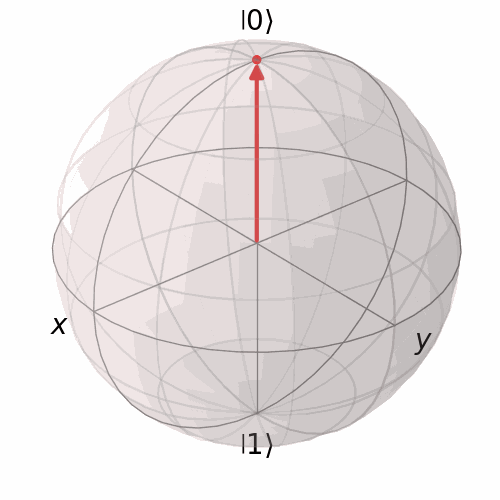

In [3]:
Image(filename='test.gif')

<h2>
    <center>
        Two non-interacting atoms with different frequencies
    </center>
</h2>

Suppose that we have two non-interacting atoms with different frequencies. The Hamiltonian of the system is

$$
H = \frac{\hbar \omega_1}{2} \sigma_1^\dagger \sigma_1 + \frac{\hbar \omega_2}{2} \sigma_2^\dagger \sigma_2
$$

where $\omega_1$ and $\omega_2$ are the frequencies of the two atoms. For simplicity, we assume that the decay time is much longer than the time scale of the experiment. 

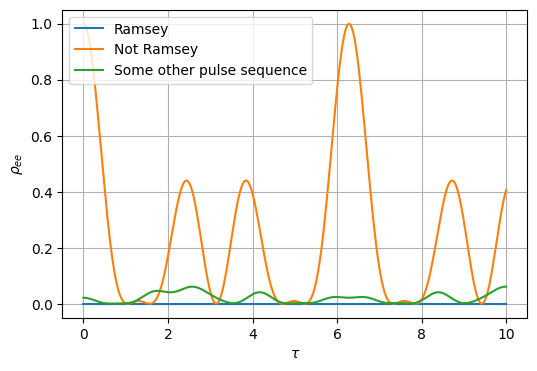

In [129]:
tlist = np.linspace(0, 10, 300)
sys = N_dipole_system(2)
sys.H = sys.sm_list[0].dag() * sys.sm_list[0] + sys.sm_list[1].dag() * sys.sm_list[1] * 1.5

rho_e_ramsey = [sys.pulse_sequence(t, [np.pi/2, np.pi, np.pi/2]) for t in tlist]
rho_e_not_ramsey = [sys.pulse_sequence(t, [np.pi/2, 0, np.pi/2]) for t in tlist]
rho_e_whatever = [sys.pulse_sequence(t, [np.pi/2, np.pi/2, np.pi/2, np.pi/4]) for t in tlist]

plt.figure(figsize=(6,4))
plt.plot(tlist, rho_e_ramsey, label='Ramsey')
plt.plot(tlist, rho_e_not_ramsey, label='Not Ramsey')
plt.plot(tlist, rho_e_whatever, label='Some other pulse sequence')
plt.grid(True)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\rho_{ee}$')
plt.legend()

In [130]:
sys = N_dipole_system(2)
sys.H = sys.sm_list[0].dag() * sys.sm_list[0] + sys.sm_list[1].dag() * sys.sm_list[1] * 1.5
sys.pulse_sequence(2*np.pi, [np.pi/2, np.pi, np.pi/2], points_pulse=10, points_evolve=25)
sys.animate_bloch('uncoupled_qubits.gif', duration=60)

C:\Users\chris\AppData\Local\Temp\ipykernel_32148\3552055167.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


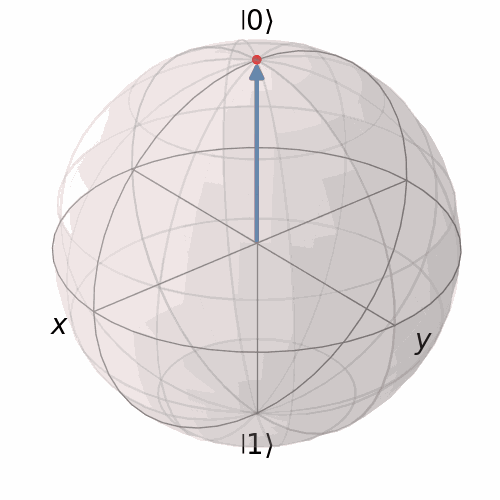

In [131]:
Image(filename='uncoupled_qubits.gif')

<h2>
    <center>
        Two interacting atoms with the same frequency
    </center>
</h2>

The Hamiltonian of the system is

$$
H=\sum_{i}\omega_{i}\sigma_{i}^{\dagger}\sigma_{i}+\sum_{i\ne j}J_{ij}\sigma_{i}^{\dagger}\sigma_{j}
$$


In [ ]:
tlist = np.linspace(0, 10, 300)
sys = N_dipole_system(2)
sys.H = sys.sm_list[0].dag() * sys.sm_list[0] + sys.sm_list[1].dag() * sys.sm_list[1] * 1.5

rho_e_ramsey = [sys.pulse_sequence(t, [np.pi/2, np.pi, np.pi/2]) for t in tlist]
rho_e_not_ramsey = [sys.pulse_sequence(t, [np.pi/2, 0, np.pi/2]) for t in tlist]
rho_e_whatever = [sys.pulse_sequence(t, [np.pi/2, np.pi/2, np.pi/2, np.pi/4]) for t in tlist]

plt.figure(figsize=(6,4))
plt.plot(tlist, rho_e_ramsey, label='Ramsey')
plt.plot(tlist, rho_e_not_ramsey, label='Not Ramsey')
plt.plot(tlist, rho_e_whatever, label='Some other pulse sequence')
plt.grid(True)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\rho_{ee}$')
plt.legend()

In [ ]:
sys = N_dipole_system(2)
sys.H = sys.sm_list[0].dag() * sys.sm_list[0] + sys.sm_list[1].dag() * sys.sm_list[1] * 1.5
sys.pulse_sequence(2*np.pi, [np.pi/2, np.pi, np.pi/2], points_pulse=10, points_evolve=25)
sys.animate_bloch('ising_model.gif', duration=60)

In [ ]:
Image(filename='ising_model.gif')